In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.ion() # (%matplotlib inline)
import os

# Patch Perfect

This notebook will document the process we underwent to find a solution to the plothole-problem.


### EDA

We start by looking at the data systematically to see where we will inevitably need to solve problems before we create a model:

In [2]:
__file__ = os.path.abspath('') # notebooks are stupid
DATA_DIR = Path(__file__).resolve() / "data"
TRAIN_LABELS_PATH = DATA_DIR / "train_labels.csv"

train_label_df = pd.read_csv(filepath_or_buffer=TRAIN_LABELS_PATH)
train_label_df.rename(columns={'Bags used ': 'Bags used'}, inplace=True)

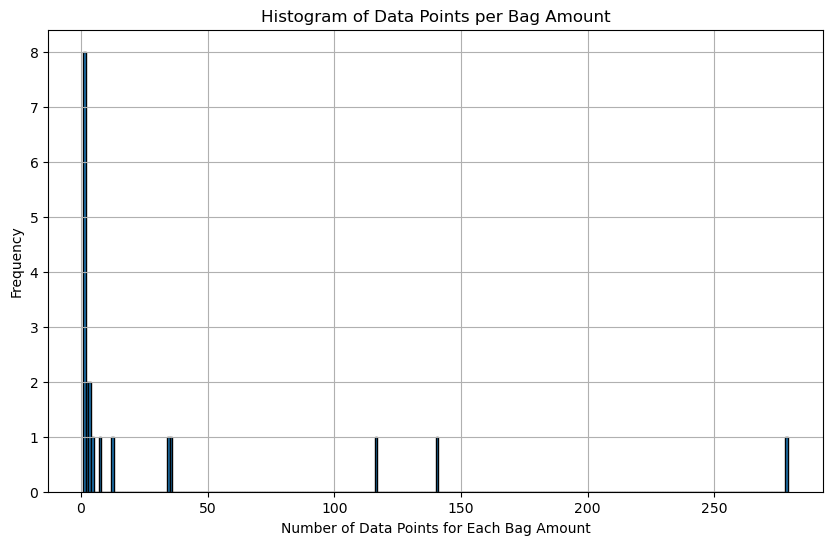

In [3]:
values = train_label_df.loc[:, 'Bags used'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(values, bins=range(1, max(values) + 2), edgecolor='black')
plt.title('Histogram of Data Points per Bag Amount')
plt.xlabel('Number of Data Points for Each Bag Amount')
plt.ylabel('Frequency')
plt.grid(True)


In [4]:
values

0.50     278
0.25     140
1.00     116
1.50      35
2.00      34
3.00      12
2.50       7
0.55       4
8.00       3
1.05       3
1.55       2
4.00       2
5.00       1
15.00      1
3.10       1
3.05       1
5.50       1
7.00       1
2.05       1
12.00      1
Name: Bags used, dtype: int64

We can see that there is a massive class imbalance. This could create issues where a model trained on this dataset has a bias towards more common bags. Most values are between 0 and 1 with some values much higher. There are many strategies we could use to solve this, including but not limited to: 
<ul>
<li>Some label abstraction technique where we might create labels based on a logarithmic scale</li>
<li>Data augmentation as a class imbalance mitigation: This process is called upsampling</li>
</ul>

We should also consider the following: The data makes this problem seem like a regression model is needed, but tuning the labels may enable us to change it to a much simpler classification task at the cost of some accuracy. Doing this would result in a much more robust model and enable us to use techniques like label smoothing to let the model generalize more to unseen data. 
<hr>
References:
<ul>
<li>Paperspace Blog. (2022). Data Augmentation: A Class Imbalance Mitigative Measure. [online] Available at: https://blog.paperspace.com/data-augmentation-a-class-imbalance-mitigative-measure/.</li>
<li>S. Wang and X. Yao, "Multiclass Imbalance Problems: Analysis and Potential Solutions," in IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 42, no. 4, pp. 1119-1130, Aug. 2012, doi: 10.1109/TSMCB.2012.2187280. keywords: {Training;Correlation;Training data;Pattern analysis;Genetic algorithms;IEEE Potentials;Cybernetics;Boosting;diversity;ensemble learning;multiclass imbalance problems;negative correlation learning}, </li>
</ul>
‌

In [11]:
import torch
from torch import nn
from ultralyticsplus import YOLO, render_result

# load model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")


Using cache found in /home/johan/.cache/torch/hub/ultralytics_yolov5_master
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
ERROR: Ignored the following versions that require a different python version: 10.0.0 Requires-Python >=3.8; 10.0.1 Requires-Python >=3.8; 10.1.0 Requires-Python >=3.8; 10.2.0 Requires-Python >=3.8; 10.3.0 Requires-Python >=3.8; 10.4.0 Requires-Python >=3.8
ERROR: Could not find a version that satisfies the requirement pillow>=10.3.0 (from versions: 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7.0, 1.7.1, 1.7.2, 1.7.3, 1.7.4, 1.7.5, 1.7.6, 1.7.7, 1.7.8, 2.0.0, 2.1.0, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.3.2, 2.4.0, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.7.0, 2.8.0, 2.8.1, 2.8.2, 2.9.0, 3.0.0, 3.1.0rc1, 3.1.0, 3.1.1, 3.1.2, 3.2.0, 3.3.0, 3.3.1, 3.3.2, 3.3.3, 3.4.0, 3.4.1, 3.4.2, 4.0.0, 4.1.0, 4.1.1, 4.2.0, 4.2.1, 4.3.0, 5.0.0, 5.1.0, 5.2.0, 5.3.0, 5.4.0, 5.4.1, 6.0.0, 6.1.0, 6.2.0, 6.2.1, 6.2.2,

In [10]:
model.fc = nn.Sequential()